# Sleep Overall Score Model Multiple Files
Training a model to predict energy next day from sleep.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [3]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [4]:
result_df = day_data.copy()
target_col = "energy:energyScore"

In [5]:
[col for col in result_df.columns if 'fdelta' in col]

['night:yasaExtended:All:fdeltaabs_s:mean',
 'night:yasaExtended:N2:fdeltaabsaa_s:mean',
 'night:yasaExtended:SleepHour1To2:fdeltaabsaa_s:mean',
 'night:yasaExtended:Sleep:fdeltaabs_s:mean',
 'night:yasaExtended:30MinsBeforeSleep:fdeltaabsaa_s:mean',
 'night:yasaExtended:30MinsBeforeSleep:fdeltaaa_s:mean',
 'night:yasaExtended:N2:fdeltaabs_s:mean',
 'night:yasaExtended:60MinsBeforeSleep:fdeltaabsab_s:mean',
 'night:yasaExtended:60MinsBeforeReadyToSleep:fdeltaab_s:mean',
 'night:yasaExtended:All:fdeltaab_s:mean',
 'night:yasaExtended:60MinsBeforeSleep:fdelta_s:mean',
 'night:yasaExtended:SleepHour1To2:fdeltaaa_s:mean',
 'night:yasaExtended:All:fdeltaabsab_s:mean',
 'night:yasaExtended:15MinsBeforeReadyToSleep:fdeltaab_s:mean',
 'night:yasaExtended:W:fdeltaaa_s:mean',
 'night:yasaExtended:60MinsBeforeReadyToSleep:fdelta_s:mean',
 'night:yasaExtended:R:fdeltaabs_s:mean',
 'night:yasaExtended:NREM:fdeltaaa_s:mean',
 'night:yasaExtended:R:fdeltaabsaa_s:mean',
 'night:yasaExtended:SleepHour1

In [7]:
result_df["energy:energyScore"].describe()

count    103.000000
mean      40.758025
std       27.030008
min       10.000000
25%       20.000000
50%       32.919094
75%       50.000000
max      120.000000
Name: energy:energyScore, dtype: float64

# Prepare data

In [62]:
from memory import garbage_collect
from dataclasses import dataclass
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import pandas as pd
import json


import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

# Custom Transformer to remove highly correlated percentile columns
class RemoveHighlyCorrelatedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.97):
        self.threshold = threshold
        self.columns_to_remove_ = []

    def fit(self, X, y=None):
        # Iterate through each column in X
        for col in X.columns:
            # Replace "percentile90" or "percentile10" with "mean"
            new_col = col.replace('percentile90', 'mean').replace('percentile10', 'mean')

            # Check if the new "mean" column exists and it's not the same as the original column
            if new_col in X.columns and col != new_col:
                # Calculate the correlation
                correlation = X[col].corr(X[new_col])

                # If correlation is greater than or equal to the threshold, mark the column for removal
                if correlation >= self.threshold:
                    self.columns_to_remove_.append(col)

        return self

    def transform(self, X, y=None):
        # Drop the columns that are highly correlated with their corresponding mean columns
        return X.drop(columns=self.columns_to_remove_, errors='ignore')


class RowsWithTargetCol(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        out = result_df[~result_df['energy:energyScore'].isna()]
        print(f"RowsWithTargetCol: before {len(X)} rows after {len(out)} rows")
        return out


class DropAllEnergyCols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        useful_features = [col for col in X.columns if (target_col == col or 'energy' not in col)]
        return X[useful_features]


class DropFlakyCols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        useful_features = [col for col in X.columns if (target_col == col or 'presence:' not in col)]
        return X[useful_features]
    
class DropNonEEGDataIfNeeded(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, sources: list[str]):
        self.target_col = target_col
        self.sources = sources

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        need_eeg = "eeg" in self.sources or "eeg_deep" in self.sources or "only_sleep_score_features" in self.sources
        if need_eeg:
            return X[X['night:yasaExtended:All:sdelta_s:mean'].notna()]
        return X

def only_under_my_control(ml_key: str) -> bool:
    lower = ml_key.lower()
    return (ml_key.startswith("drugsAndSupplements")
            or "gotintobed" in lower
            or ml_key.startswith("exercise")
            or ml_key.startswith("sunExposure")
            or ml_key.startswith("bedroomEnvironment")
            or ml_key.startswith("events")
            or ml_key.startswith("food")
            or ml_key.startswith("oxa")
            or "asleepTimeSSM" in ml_key
            or "hasYasa" in ml_key
            or "readyToSleepTime" in ml_key
            or "pees" in ml_key
            or "fitbit:heartrate" in ml_key
            or ml_key.startswith("hr"))


class UsefulFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, sources: list[str]):
        self.target_col = target_col
        self.sources = sources
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Just not really ready for primetime
        not_ready_for_primetime = ["presence:", "settling:"]
        useless = ["generatedAt", "hasYasa", "morningQuestionnaire"]
        do_not_want_in_model = ["date:", "-M1", "Fpz", "perment"]
        # Will want to use adjusted instead
        duplicates = ["night:fitbit:source:", "night:yasa:source:"]
        # Need to debug
        not_present_on_all_rows_for_some_reason = ["SleepHour", "Stability:Aggregated", "TiredVsWired", "BeforeSleep", "ReadyToSleep"]
        remove_list = not_ready_for_primetime + useless + do_not_want_in_model + duplicates + not_present_on_all_rows_for_some_reason
        
        remove_if_includes_list = ["energy"]

        useful_features = [col for col in X.columns \
                           if (self.target_col in col) \
                            # Part of target list
                            #and not 'energy' in col \
                            or not any(rem in col for rem in remove_list)
                           ]
        
        if "eeg_deep" in self.sources:
            useful_features = [col for col in useful_features if ('yasa' in col.lower() and (('deep' in col.lower()) or 'N3' in col)) or self.target_col in col]
        if "eeg" in self.sources:
            useful_features = [col for col in useful_features if ('yasa' in col.lower()) or self.target_col in col]
        if "only_under_my_control" in self.sources:
            useful_features = [col for col in useful_features if only_under_my_control(col) or self.target_col in col]
        if "only_sleep_score_features" in self.sources:
            features = [
                "night:aggregated:totalSleepTimeSecs",
                "night:yasa:adjusted:wakingsWithDurationCount",
                "night:yasaExtended:Sleep:fdelta_s:mean",
                "night:yasaExtended:N3:sdelta_s:mean",
                "night:aggregated:timeAwakeAfterSleepSecs",
                "night:yasa:adjusted:lightSleepSecs",
                "night:yasa:adjusted:remSleepSecs",
                "night:yasaExtended:Sleep:sdeltaabs_s:mean",
                "night:yasaExtended:Sleep:iqr_s:mean",
                "night:yasaExtended:Sleep:theta_s:mean",
                "circadian:combined:entries:NL:temp",
                "night:yasaExtended:N2:skew_s:mean",
                "night:yasaExtended:Sleep:abspow_s:mean",
                "night:yasaExtended:N3:skew_s:mean",
                "night:yasaExtended:SlowWaves:Fpz-M1:ValNegPeak",
                "night:yasaExtended:Stability:Aggregated:N2",
                "night:yasaExtended:Sleep:auc_s:mean"
            ]
            useful_features = [col for col in useful_features if (col in features) or self.target_col in col]
        
        
        
        return X[useful_features].select_dtypes(exclude=['object', 'datetime64[ns]', 'datetime64[ns, Europe/London]'])

class DropNaNRows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Identify rows with NaN values
        nan_rows = X.isna().any(axis=1)

        # Log the indexes of dropped and kept rows
        dropped_indexes = X[nan_rows].index.tolist()
        kept_indexes = X[~nan_rows].index.tolist()

        # Log the first column that had NaN for each dropped row
        reasons = X[nan_rows].apply(lambda row: row[row.isna()].index[0], axis=1).tolist()

        print(f"Dropped row indexes: {dropped_indexes}")
        print(f"Kept row indexes: {kept_indexes}")
        print(f"Reasons for dropping: {reasons}")

        out = X.dropna()
        print(f"DropNaNRows: before {len(X)} rows after {len(out)} rows")
        return out

class DropBadRows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Identify rows with NaN values
        bad_rows = X.isin([np.inf, -np.inf]).any(axis=1)

        # Log the indexes of dropped and kept rows
        dropped_indexes = X[bad_rows].index.tolist()
        kept_indexes = X[~bad_rows].index.tolist()

        # Log the first column that had NaN for each dropped row
        reasons = X[bad_rows].apply(lambda row: row[row.isin([np.inf, -np.inf])].index[0], axis=1).tolist()

        print(f"Dropped row indexes: {dropped_indexes}")
        print(f"Kept row indexes: {kept_indexes}")
        print(f"Reasons for dropping: {reasons}")

        out = X[~bad_rows]
        print(f"DropBadRows: before {len(X)} rows after {len(out)} rows")
        return out

# Get EEG deep features.  Ignore Fitbit.
class EEGDeepFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        useful_features = [col for col in X.columns if ('onDayMinus1' in col and 'yasa' in col.lower() and (('deep' in col.lower()) or 'N3' in col)) or target_col in col]
        return X[useful_features]

# Get things that happen before night.
class BeforeNightFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # We still want thinks the day before, as we are interested in energy next day.
        useful_features = [col for col in X.columns if (('onDayMinus1' in col or target_col in col) and 'night:' not in col)]
        return X[useful_features]


# Drop columns where we don't have much data
class DropFewValidColumns(BaseEstimator, TransformerMixin):
    def __init__(self, min_valid=5):
        self.min_valid = min_valid  # Minimum valid values required to keep the column
        self.columns_to_keep_ = None  # Will store the columns to keep

    def fit(self, X, y=None):
        # Identify columns where the count of non-NaNs is at least min_valid
        valid_counts = X.notna().sum()
        self.columns_to_keep_ = valid_counts[valid_counts >= self.min_valid].index.tolist()
        return self  # Return self to comply with scikit-learn's fit API

    def transform(self, X, y=None):
        # Keep only the identified columns with at least min_valid non-NaNs
        return X[self.columns_to_keep_]


@dataclass
class ModelAndData:
    name: str
    target_col: str
    sources: list[str]
    prepared_df: pd.DataFrame
    X: pd.DataFrame
    y: pd.Series
    model: object = None
    X_train: pd.DataFrame = None
    y_train: pd.Series = None
    X_val: pd.DataFrame = None
    y_val: pd.Series = None


garbage_collect(log)

modelsAndData: list[ModelAndData] = []

def create_and_add(target_col: str, sources: list[str], input):
    name = f"target:{target_col} sources:{sources}"

    pipeline = Pipeline([
        ('rows', RowsWithTargetCol()),
        ('drop_energy', DropAllEnergyCols()),
        ('drop_non_eeg_data_if_needed', DropNonEEGDataIfNeeded(target_col, sources)),
        ('features', UsefulFeatures(target_col, sources)),
        # Only really needed for linear regression
        #('drop_nan', DropNaNRows()),
        # ('drop_bad', DropBadRows()),
        ('drop_few_values', DropFewValidColumns()),
        ('remove_highly_correlated', RemoveHighlyCorrelatedColumns(threshold=0.97)),
    ])

    prepared_df = pipeline.fit_transform(input)

    X = prepared_df.drop(columns=[target_col])
    # X = prepared_df
    y = prepared_df[target_col]
    # y = prepared_df

    md = ModelAndData(name, target_col, sources, prepared_df, X, y)
    modelsAndData.append(md)


# create_and_add("energy:energyScore", ["only_under_my_control"], result_df)
# create_and_add("energy:energyScore", ["all"], result_df)

create_and_add("energy:energyScore", ["eeg"], result_df)
# create_and_add("energy:energyScore", ["only_sleep_score_features"], result_df)
# create_and_add("energy:energyScore", ["eeg_deep"], result_df)
# create_and_add("energy:energyScore", ["before_night"], result_df)


# prepared_df_all_features, X_all_features, y_all_features = pipeline_all_features(result_df)
# prepared_df_eeg_deep, X_eeg_deep, y_eeg_deep = pipeline_eeg_deep(result_df)
# prepared_df_before_night, _, _ = pipeline_before_night(result_df)
# 
# print([col for col in X_all_features.columns if ('energy' in col.lower())])
# print([col for col in X_eeg_deep.columns if ('energy' in col.lower())])
# print(len(result_df.columns))
# print(len(prepared_df_all_features.columns))
# print(len(prepared_df_eeg_deep.columns))
# print(len(prepared_df_before_night.columns))

from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in modelsAndData:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")


RowsWithTargetCol: before 244 rows after 103 rows
Training set size target:energy:energyScore sources:['eeg']: 49, validation set size: 6


In [63]:
[col for col in modelsAndData[0].X.columns if "theta" in col]

['night:yasaExtended:N3:thetaabs_s:mean',
 'night:yasaExtended:N3:thetaabsaa_s:mean',
 'night:yasaExtended:R:thetaabsaa_s:mean',
 'night:yasaExtended:R:thetaaa_s:mean',
 'night:yasaExtended:N1:thetaab_s:mean',
 'night:yasaExtended:N2:thetaabsaa_s:mean',
 'night:yasaExtended:W:theta_s:mean',
 'night:yasaExtended:Sleep:thetaabsaa_s:mean',
 'night:yasaExtended:N1:thetaabsaa_s:mean',
 'night:yasaExtended:W:thetaabsaa_s:mean',
 'night:yasaExtended:N3:thetaabsab_s:mean',
 'night:yasaExtended:All:thetaaa_s:mean',
 'night:yasaExtended:All:thetaabsaa_s:mean',
 'night:yasaExtended:N2:thetaab_s:mean',
 'night:yasaExtended:Sleep:thetaaa_s:mean',
 'night:yasaExtended:N2:theta_s:mean',
 'night:yasaExtended:R:theta_s:mean',
 'night:yasaExtended:All:thetaabs_s:mean',
 'night:yasaExtended:All:theta_s:mean',
 'night:yasaExtended:N2:thetaaa_s:mean',
 'night:yasaExtended:W:thetaabsab_s:mean',
 'night:yasaExtended:NREM:thetaabs_s:mean',
 'night:yasaExtended:W:thetaaa_s:mean',
 'night:yasaExtended:N1:thetaa

In [64]:
modelsAndData[0].X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 81 to 242
Columns: 421 entries, night:yasaExtended:R:sigmaabsab_s:mean to night:yasaExtended:finalWakeModel:minsUntilWakeAllEpochsPredictionMeanError
dtypes: float64(421)
memory usage: 181.3 KB


In [42]:
import pandas as pd

df = modelsAndData[0].X
nan_counts = df.isna().sum().reset_index()
nan_counts.columns = ['Column', 'NaN Count']

# Calculate the count of not-NaN rows for each column
not_nan_counts = df.notna().sum().reset_index(drop=True)
nan_counts['Not-NaN Count'] = not_nan_counts

nan_counts

,Column,NaN Count,Not-NaN Count
0,food:aggregated:meals:afternoonSnacks:proteinG...,3,100
1,food:aggregated:meals:morningSnacks:calories,3,100
2,food:aggregated:meals:morningNonDrink:calories,3,100
3,exercise:byExercise:Any:totalSteps,0,103
4,food:aggregated:meals:dinner:proteinGrams,3,100
...,...,...,...
581,events:phoneAwayFromBed:count,87,16
582,events:phoneAwayFromBed:firstSSM,87,16
583,events:phoneAwayFromBed:lastSSM,87,16
584,drugsAndSupplements:MagnesiumThreonateLastSSM,95,8


# Train XGBoost model

In [65]:
from models.util.rfe_training import train_rfe
import xgboost as xgb


import memory

memory.garbage_collect(print)


for md in modelsAndData:
    def get_model():
        model = xgb.XGBRegressor(
            # n_estimators=10,
            # max_depth=6,
            # learning_rate=0.1,
        )
        return (model, {
            "source": "xgb"
        })

    md.models = train_rfe(get_model, md.name, md.X_train, md.y_train, md.X_val, md.y_val)

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
evaluation.evaluate_regression_models(modelsAndData)


Memory Usage: 469.00 MB GC to 469.00 MB
Training RFE model for target:energy:energyScore sources:['eeg'] with 421 features... RMSE train: 0.0003561214719249082 RMSE val: 37.522774886294044
Training RFE model for target:energy:energyScore sources:['eeg'] with 210 features... RMSE train: 0.0003561214719249082 RMSE val: 37.252329417189785
Training RFE model for target:energy:energyScore sources:['eeg'] with 105 features... RMSE train: 0.00040668572008113654 RMSE val: 36.83171364595925
Training RFE model for target:energy:energyScore sources:['eeg'] with 52 features... RMSE train: 0.00039067818309627863 RMSE val: 36.64476287956771
Training RFE model for target:energy:energyScore sources:['eeg'] with 26 features... RMSE train: 0.00044492189861823004 RMSE val: 35.2277806932287
Training RFE model for target:energy:energyScore sources:['eeg'] with 13 features... RMSE train: 0.0005557448637748755 RMSE val: 37.60730700574626
Training RFE model for target:energy:energyScore sources:['eeg'] with 9

,Rows_Train,MAE_Train,MAE_Val,MSE_Train,MSE_Val,RMSE_Train,RMSE_Val,Model,n_features,source
0,49,0.000251,33.182393,1.268225e-07,1407.958635,0.000356,37.522775,target:energy:energyScore sources:['eeg'],421,xgb
1,49,0.000251,34.103122,1.268225e-07,1387.736047,0.000356,37.252329,target:energy:energyScore sources:['eeg'],210,xgb
2,49,0.000277,33.269307,1.653933e-07,1356.575130,0.000407,36.831714,target:energy:energyScore sources:['eeg'],105,xgb
3,49,0.000272,32.511930,1.526294e-07,1342.838646,0.000391,36.644763,target:energy:energyScore sources:['eeg'],52,xgb
4,49,0.000327,32.098778,1.979555e-07,1240.996533,0.000445,35.227781,target:energy:energyScore sources:['eeg'],26,xgb
5,49,0.000385,34.357651,3.088524e-07,1414.309540,0.000556,37.607307,target:energy:energyScore sources:['eeg'],13,xgb
6,49,0.000471,33.540868,4.253114e-07,1322.251133,0.000652,36.362771,target:energy:energyScore sources:['eeg'],9,xgb
7,49,0.000549,20.553836,7.144288e-07,740.130139,0.000845,27.205333,target:energy:energyScore sources:['eeg'],5,xgb


In [69]:
bm = modelsAndData[0].models[2]
bst = bm.model

Evaluation for model:  best model
best model Training Set Evaluation:
MAE: 0.0002766034788502814, MSE: 1.6539327491791255e-07, RMSE: 0.00040668572008113654


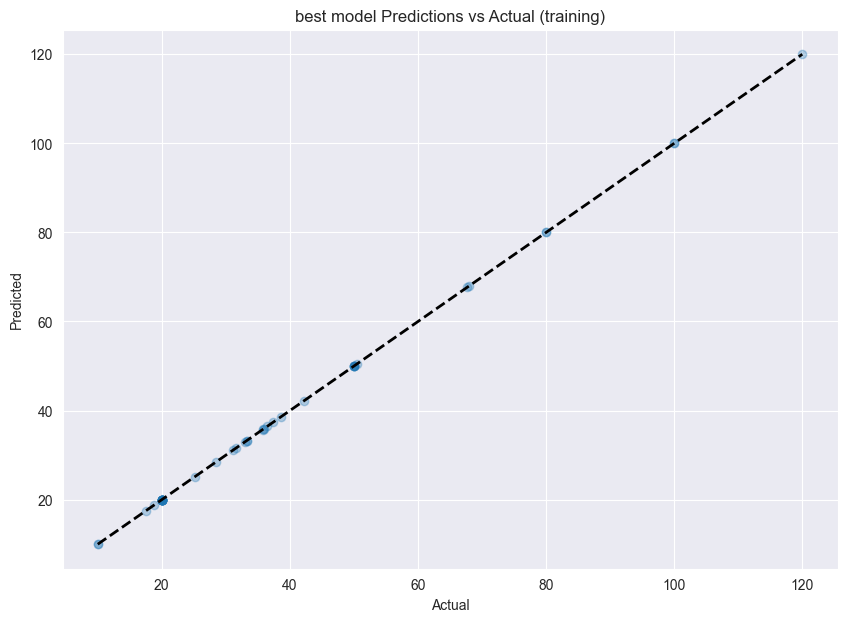

best model Validation Set Evaluation:
MAE: 33.26930657877008, MSE: 1356.5751300979407, RMSE: 36.83171364595925


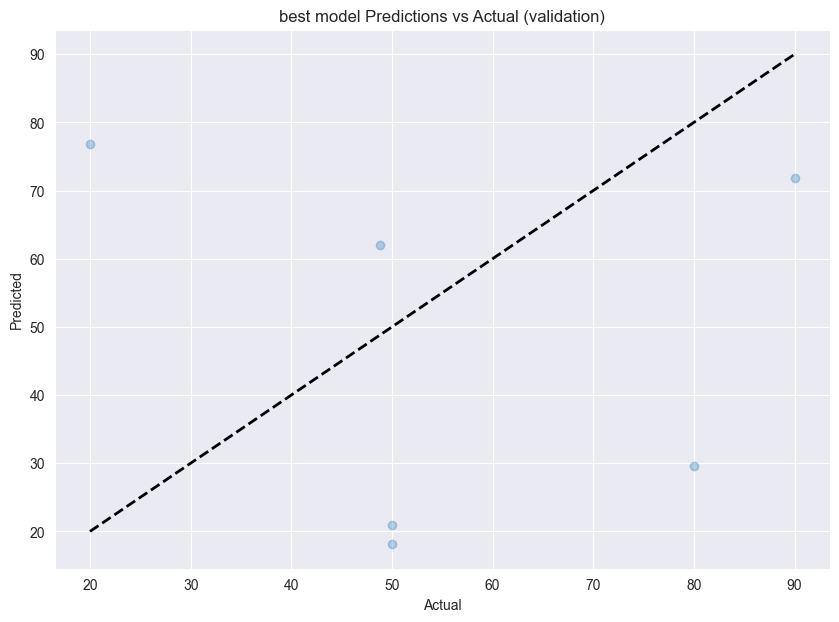

In [74]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_regression_model(bm.model, "best model", bm.X_train, bm.y_train, bm.X_val, bm.y_val)


In [75]:
# Install SHAP if you haven't already
# !pip install shap

import shap
import xgboost as xgb

# Create a DMatrix for SHAP
# dmatrix = xgb.DMatrix(bm.X_train)

# Initialize the SHAP explainer
explainer = shap.Explainer(bm.model)

# Calculate SHAP values
shap_values = explainer(bm.X_train)

shap_values.shape

(49, 105)

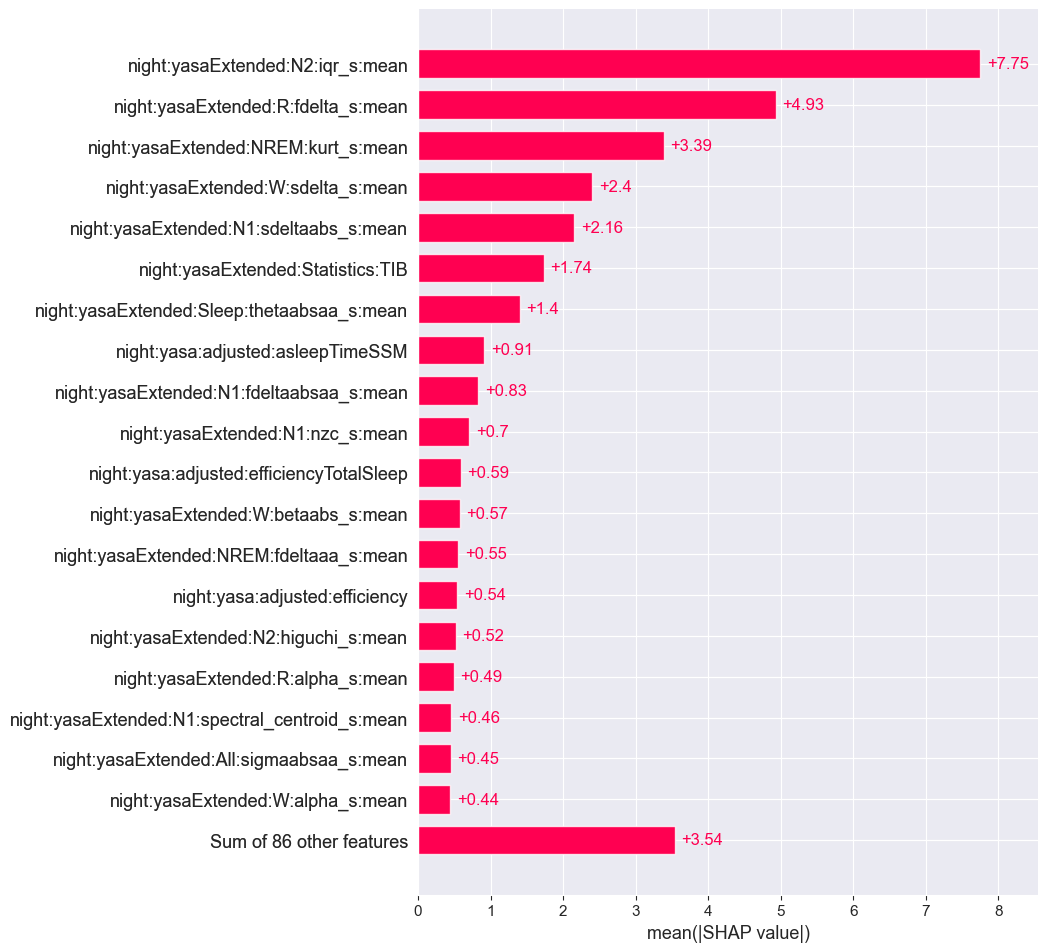

In [76]:
shap.plots.bar(shap_values, max_display=20)


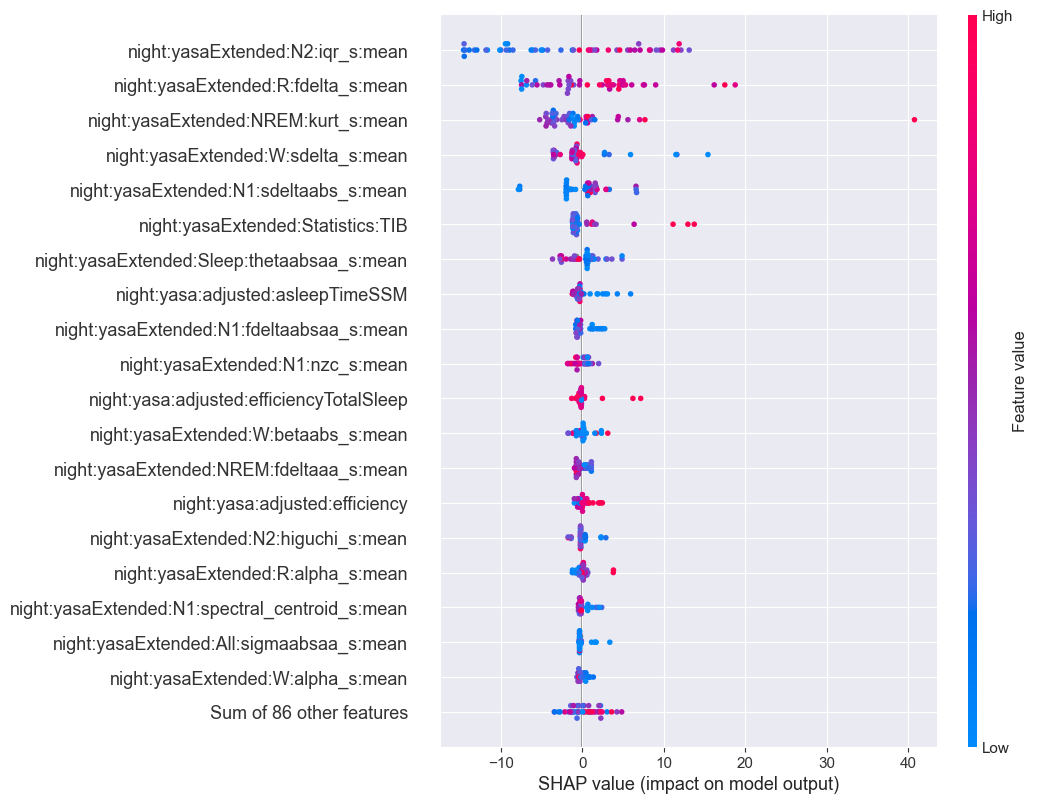

In [77]:
shap.plots.beeswarm(shap_values, max_display=20)


# Train with Catboost

In [30]:

import catboost as cb
from catboost import Pool
import models.util.importances as importances
from importlib import reload
reload(importances)

import models.util.rfe_training as rfe_training
from importlib import reload
reload(rfe_training)

def train_catboost(X, y):
    # Create a Pool object
    train_pool = Pool(data=X, label=y)
    
    # Define the parameters for the CatBoost model
    params = {
        'iterations': 100,
        # 'eval_metric': 'Accuracy',    # Evaluation metric
        'depth': 6,
        'learning_rate': 0.1,
        'loss_function': 'RMSE',
        "task_type": "GPU"
        # 'reg_alpha': 5,
        # 'l2_leaf_reg': 3,  # L2 regularization term
        # 'border_count': 32  # Reducing the number of splits
    }
    
    
    # Train the model on the entire dataset
    model = cb.CatBoostRegressor(**params)
    model.fit(train_pool)

    from sklearn.feature_selection import RFE
    
    selector = RFE(model, n_features_to_select=9, step=0.05)
    selector = selector.fit(X, y)
    selected_features = X.columns[selector.support_]

    X_selected = X[selected_features]
    train_pool_selected = Pool(data=X_selected, label=y)
    model.fit(train_pool_selected)

    # Perform k-fold cross-validation
    cv_results = cb.cv(
        pool=train_pool,
        params=params,
        fold_count=5,
        shuffle=True,
        partition_random_seed=42,
        plot=True
    )

    # Print the cross-validation results
    print(cv_results)
    
    print("Selected features:", selected_features)
    return model, selected_features

for md in modelsAndData:
    def get_model():
        params = {
            'iterations': 100,
            # 'eval_metric': 'Accuracy',    # Evaluation metric
            'depth': 6,
            'learning_rate': 0.1,
            'loss_function': 'RMSE',
            "task_type": "GPU"
            # 'reg_alpha': 5,
            # 'l2_leaf_reg': 3,  # L2 regularization term
            # 'border_count': 32  # Reducing the number of splits
        }

        model = cb.CatBoostRegressor(**params)
        return (model, {
            "source": "cat"
        })

    new_models = rfe_training.train_rfe(get_model, md.name, md.X_train, md.y_train, md.X_val, md.y_val)
    md.models.extend(new_models)

evaluation.evaluate_regression_models(modelsAndData)


Training RFE model for target:energy:energyScore sources:['all'] with 1369 features0:	learn: 24.5830734	total: 5.45ms	remaining: 540ms
1:	learn: 23.9457848	total: 10.2ms	remaining: 499ms
2:	learn: 23.1809300	total: 14.7ms	remaining: 477ms
3:	learn: 22.3151075	total: 19.7ms	remaining: 473ms
4:	learn: 21.6307183	total: 24.6ms	remaining: 468ms
5:	learn: 20.9896727	total: 29.8ms	remaining: 467ms
6:	learn: 20.2435642	total: 34.8ms	remaining: 462ms
7:	learn: 19.7712968	total: 39.2ms	remaining: 451ms
8:	learn: 19.1763122	total: 43.6ms	remaining: 441ms
9:	learn: 18.6360575	total: 48.3ms	remaining: 435ms
10:	learn: 18.0930867	total: 53.3ms	remaining: 431ms
11:	learn: 17.5823645	total: 58.1ms	remaining: 426ms
12:	learn: 17.0040625	total: 62.6ms	remaining: 419ms
13:	learn: 16.5266682	total: 67.3ms	remaining: 413ms
14:	learn: 15.9141487	total: 72.4ms	remaining: 410ms
15:	learn: 15.3749867	total: 78.1ms	remaining: 410ms
16:	learn: 14.8215986	total: 83.8ms	remaining: 409ms
17:	learn: 14.4018770	tota

,Rows_Train,MAE_Train,MAE_Val,MSE_Train,MSE_Val,RMSE_Train,RMSE_Val,Model,n_features,source
0,81,0.000248,28.597441,1.152090e-07,1477.075175,0.000339,38.432736,target:energy:energyScore sources:['all'],1369,xgb
1,81,0.000248,27.433293,1.152090e-07,1402.048476,0.000339,37.443938,target:energy:energyScore sources:['all'],684,xgb
2,81,0.000248,28.007456,1.152090e-07,1437.126027,0.000339,37.909445,target:energy:energyScore sources:['all'],342,xgb
3,81,0.000266,27.647179,1.323885e-07,1440.693922,0.000364,37.956474,target:energy:energyScore sources:['all'],171,xgb
4,81,0.000287,27.235933,1.603718e-07,1348.813310,0.000400,36.726194,target:energy:energyScore sources:['all'],85,xgb
5,81,0.000355,26.651337,2.151610e-07,1340.045989,0.000464,36.606639,target:energy:energyScore sources:['all'],42,xgb
6,81,0.000349,24.654763,2.430815e-07,1137.714368,0.000493,33.730022,target:energy:energyScore sources:['all'],21,xgb
7,81,0.000512,26.770724,5.494461e-07,1374.883308,0.000741,37.079419,target:energy:energyScore sources:['all'],10,xgb
8,81,0.000614,22.219642,7.615895e-07,1191.352879,0.000873,34.515980,target:energy:energyScore sources:['all'],6,xgb
9,81,0.860406,24.920595,1.250303e+00,1086.319925,1.118170,32.959368,target:energy:energyScore sources:['all'],1369,cat


In [14]:
cb_model_eeg_deep, cb_eeg_deep_selected_features = train_catboost(X_eeg_deep, y_eeg_deep)

0:	learn: 0.3574097	total: 89.4ms	remaining: 8.85s
1:	learn: 0.3521470	total: 91.8ms	remaining: 4.5s
2:	learn: 0.3483496	total: 94ms	remaining: 3.04s
3:	learn: 0.3451065	total: 96.5ms	remaining: 2.31s
4:	learn: 0.3414259	total: 98.6ms	remaining: 1.87s
5:	learn: 0.3370664	total: 101ms	remaining: 1.58s
6:	learn: 0.3335357	total: 103ms	remaining: 1.37s
7:	learn: 0.3304784	total: 105ms	remaining: 1.21s
8:	learn: 0.3263274	total: 107ms	remaining: 1.09s
9:	learn: 0.3231713	total: 110ms	remaining: 988ms
10:	learn: 0.3212071	total: 112ms	remaining: 907ms
11:	learn: 0.3180962	total: 115ms	remaining: 840ms
12:	learn: 0.3161539	total: 118ms	remaining: 790ms
13:	learn: 0.3143888	total: 121ms	remaining: 743ms
14:	learn: 0.3123148	total: 124ms	remaining: 702ms
15:	learn: 0.3101918	total: 128ms	remaining: 673ms
16:	learn: 0.3086509	total: 132ms	remaining: 644ms
17:	learn: 0.3070148	total: 135ms	remaining: 616ms
18:	learn: 0.3057195	total: 138ms	remaining: 586ms
19:	learn: 0.3042356	total: 140ms	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5589920	test: 0.4561579	best: 0.4561579 (0)	total: 8.95ms	remaining: 886ms
1:	learn: 0.5285798	test: 0.4241996	best: 0.4241996 (1)	total: 16ms	remaining: 783ms
2:	learn: 0.5037217	test: 0.4034228	best: 0.4034228 (2)	total: 21.8ms	remaining: 704ms
3:	learn: 0.4808720	test: 0.3840364	best: 0.3840364 (3)	total: 28.7ms	remaining: 688ms
4:	learn: 0.4600932	test: 0.3696809	best: 0.3696809 (4)	total: 33.1ms	remaining: 628ms
5:	learn: 0.4423553	test: 0.3524926	best: 0.3524926 (5)	total: 38ms	remaining: 595ms
6:	learn: 0.4264041	test: 0.3431750	best: 0.3431750 (6)	total: 43.8ms	remaining: 582ms
7:	learn: 0.4131538	test: 0.3313244	best: 0.3313244 (7)	total: 50.1ms	remaining: 576ms
8:	learn: 0.4014722	test: 0.3257034	best: 0.3257034 (8)	total: 56.8ms	remaining: 575ms
9:	learn: 0.3910002	test: 0.3259056	best: 0.3257034 (8)	total: 63ms	remaining: 567ms
10:	learn: 0.3822050	test: 0.3194134	best: 0.3194134 (10)	total: 68.7ms	remaining: 556ms
11:	learn: 0.3749485	tes

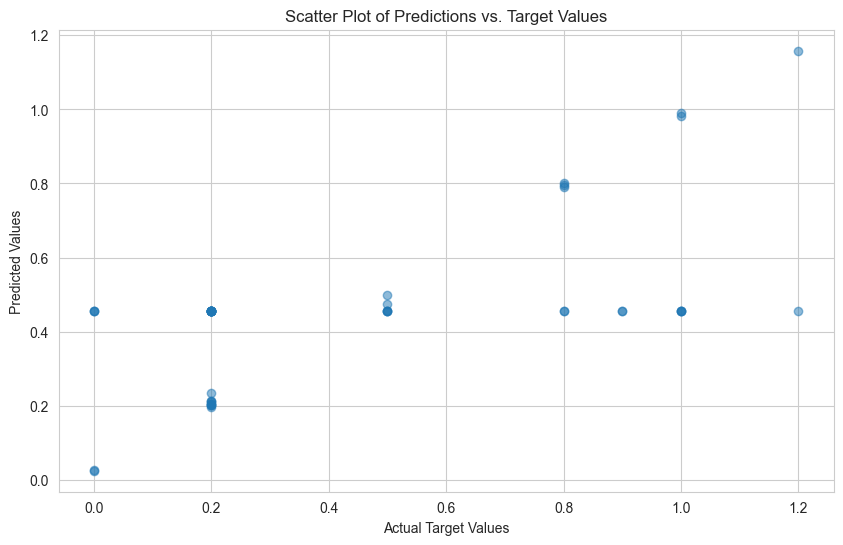

,0
count,49.000
mean,0.445
std,0.223
min,0.024
25%,0.455
50%,0.455
75%,0.455
max,1.158


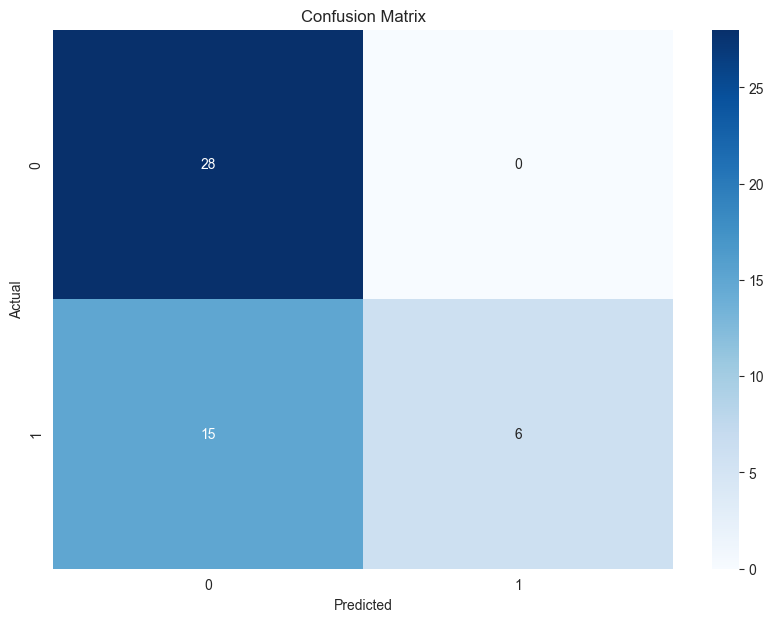

,Actual,Predicted,Diff
81,1.000,0.455,0.545
82,0.200,0.200,-0.000
85,0.800,0.455,0.345
86,1.000,0.455,0.545
87,0.200,0.455,-0.255
92,1.000,0.455,0.545
96,0.200,0.455,-0.255
97,0.200,0.455,-0.255
98,0.200,0.455,-0.255
120,1.000,0.981,0.019


,Actual,Predicted,Diff
81,1.000,0.455,0.545
82,0.200,0.200,-0.000
85,0.800,0.455,0.345
86,1.000,0.455,0.545
87,0.200,0.455,-0.255
92,1.000,0.455,0.545
96,0.200,0.455,-0.255
97,0.200,0.455,-0.255
98,0.200,0.455,-0.255
120,1.000,0.981,0.019


In [15]:
y_pred_eeg_deep = cb_model_eeg_deep.predict(X_eeg_deep)
evaluate_model(cb_model_eeg_deep, X_eeg_deep, y_eeg_deep, y_pred_eeg_deep)

,Feature,Importance,Correlation
5,night:yasaExtended:N3:specent_s:percentile10:o...,37.976,0.247
3,night:yasaExtended:N3:perment_s:percentile25:o...,23.625,0.422
7,night:yasaExtended:N3:perment_s:percentile75:o...,9.283,0.422
1,night:yasaExtended:N3:sdelta_s:percentile90:on...,8.020,0.253
6,night:yasaExtended:N3:sdelta_s:mean:onDayMinus1,6.722,0.378
4,night:yasaExtended:N3:alpha_s:percentile10:onD...,5.933,0.348
2,night:yasaExtended:Statistics:%N3:onDayMinus1,4.281,-0.215
0,night:yasaExtended:N3:at_s:percentile90:onDayM...,4.026,-0.313
8,night:yasaExtended:N3:sigma_s:percentile25:onD...,0.133,0.169


<Figure size 640x480 with 0 Axes>

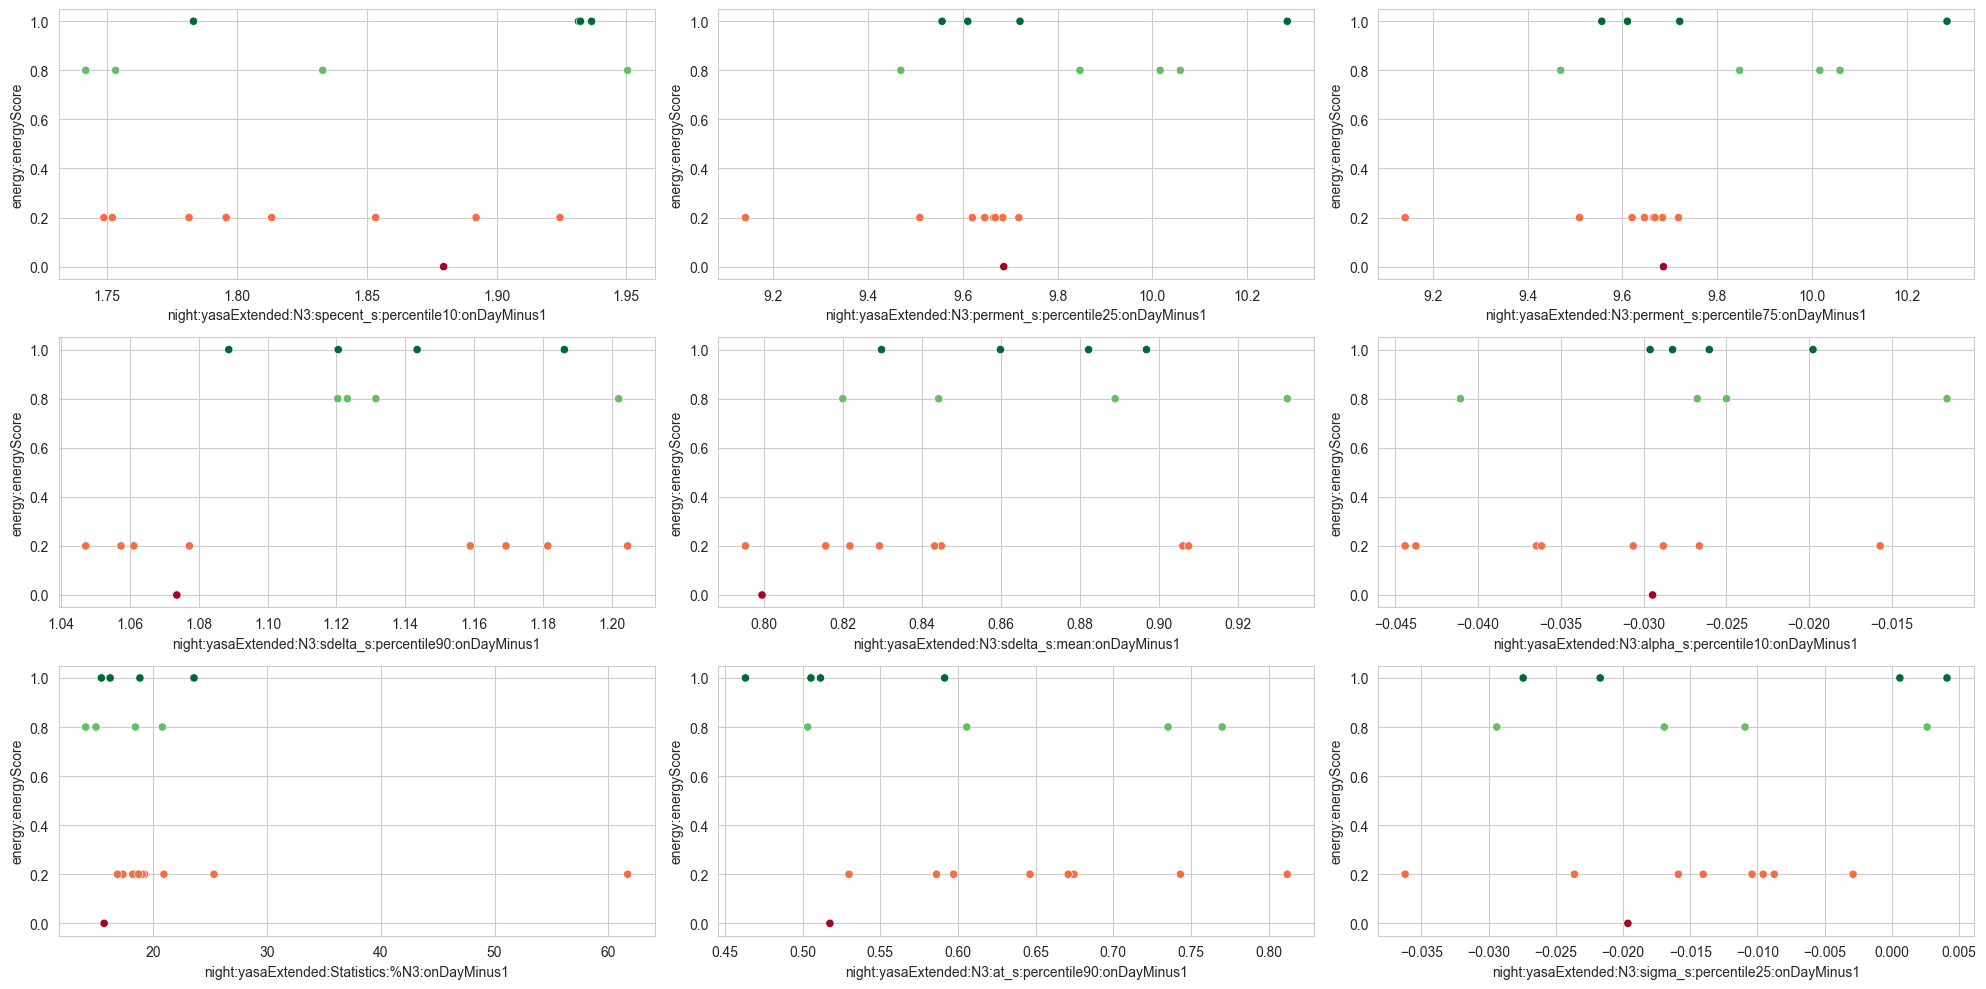

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.clf()

def evaluate_feature_importance(catboost_model, X, y, selected_features):
    importances = catboost_model.get_feature_importance()

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': selected_features.tolist(),
        'Importance': importances
    })

    # Sort the DataFrame by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    non_zero = feature_importances[feature_importances['Importance'] > 0]

    correlations = []
    for feature in non_zero['Feature']:
        correlation = X[feature].corr(y)
        correlations.append(correlation)

    non_zero['Correlation'] = correlations
    display(non_zero)

def plot_top_features(catboost_model, X, y, selected_features, top_n=9):
    importances = catboost_model.get_feature_importance()

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': selected_features.tolist(),
        'Importance': importances
    })

    # Sort the DataFrame by importance and get the top N features
    top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)['Feature']

    # Set up the plot grid
    fig, axes = plt.subplots(nrows=(top_n // 3) + (top_n % 3 > 0), ncols=3, figsize=(20, 10))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        scatter = sns.scatterplot(x=X[feature], y=y, hue=y, palette='RdYlGn', ax=axes[i])
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target_col)
        scatter.legend_.remove()  # Remove the legend

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

evaluate_feature_importance(cb_model_eeg_deep, X_eeg_deep, y_eeg_deep, cb_eeg_deep_selected_features)
plot_top_features(cb_model_eeg_deep, X_eeg_deep, y_eeg_deep, cb_eeg_deep_selected_features)

In [232]:
# cb_eeg_deep_selected_features.tolist()

['night:yasaExtended:N3:perment_s:mean:onDayMinus1',
 'night:yasaExtended:N3:dt:percentile75:onDayMinus1',
 'night:yasaExtended:N3:at_s:percentile90:onDayMinus1',
 'night:yasaExtended:N3:sdelta_s:percentile25:onDayMinus1',
 'night:yasaExtended:N3:perment:percentile10:onDayMinus1',
 'night:yasaExtended:N3:perment_s:percentile90:onDayMinus1',
 'night:yasaExtended:N3:sdelta_s:mean:onDayMinus1',
 'night:yasaExtended:N3:theta:mean:onDayMinus1',
 'night:yasaExtended:N3:sdelta:percentile25:onDayMinus1']

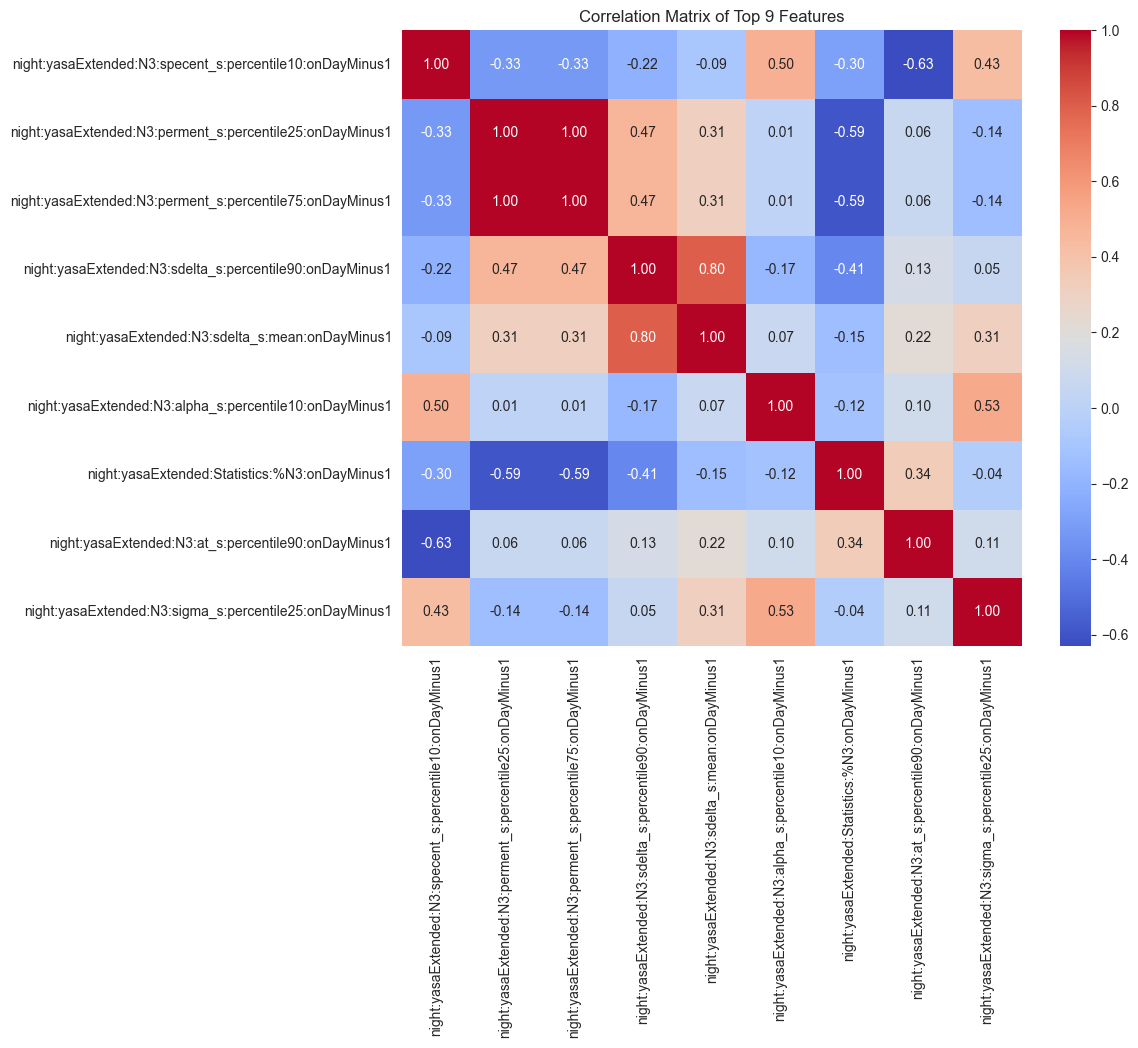

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def display_correlation_matrix(model, X, selected_features, top_n=9):
    # Extract feature importances
    importances = model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': selected_features.tolist(),
        'Importance': importances
    })

    # Sort the DataFrame by importance and get the top N features
    top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)['Feature']

    # Compute the correlation matrix for the top N features
    correlation_matrix = X[top_features].corr()

    # Display the correlation matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Top 9 Features')
    plt.show()

# Example usage with the CatBoost model
display_correlation_matrix(cb_model_eeg_deep, X_eeg_deep, cb_eeg_deep_selected_features, top_n=9)

In [ ]:
[col for col in result_df.columns if 'deepSleep' in col]

In [ ]:
[col for col in X_eeg_deep.columns if 'deepSleep' in col]

In [320]:
cb_model_all_features, cb_all_selected_features = train_catboost(X_all_features, y_all_features)


0:	learn: 0.3305038	total: 7.83ms	remaining: 775ms
1:	learn: 0.3164058	total: 13.3ms	remaining: 651ms
2:	learn: 0.3037111	total: 19ms	remaining: 616ms
3:	learn: 0.2922081	total: 24.8ms	remaining: 595ms
4:	learn: 0.2798137	total: 30.6ms	remaining: 581ms
5:	learn: 0.2689542	total: 36.3ms	remaining: 569ms
6:	learn: 0.2557845	total: 41.7ms	remaining: 554ms
7:	learn: 0.2456802	total: 48.3ms	remaining: 555ms
8:	learn: 0.2367317	total: 55.2ms	remaining: 558ms
9:	learn: 0.2262467	total: 61.2ms	remaining: 551ms
10:	learn: 0.2179696	total: 69.1ms	remaining: 559ms
11:	learn: 0.2100975	total: 74.9ms	remaining: 549ms
12:	learn: 0.2007182	total: 80.7ms	remaining: 540ms
13:	learn: 0.1931335	total: 86.8ms	remaining: 533ms
14:	learn: 0.1849558	total: 92.7ms	remaining: 525ms
15:	learn: 0.1773469	total: 98.5ms	remaining: 517ms
16:	learn: 0.1705974	total: 104ms	remaining: 508ms
17:	learn: 0.1642658	total: 112ms	remaining: 510ms
18:	learn: 0.1589740	total: 119ms	remaining: 508ms
19:	learn: 0.1522031	total:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5364903	test: 0.4896586	best: 0.4896586 (0)	total: 19.6ms	remaining: 1.94s
1:	learn: 0.5064654	test: 0.4829219	best: 0.4829219 (1)	total: 43.4ms	remaining: 2.13s
2:	learn: 0.4732481	test: 0.4648311	best: 0.4648311 (2)	total: 60.8ms	remaining: 1.96s
3:	learn: 0.4490412	test: 0.4532840	best: 0.4532840 (3)	total: 73.1ms	remaining: 1.75s
4:	learn: 0.4257557	test: 0.4451479	best: 0.4451479 (4)	total: 86.1ms	remaining: 1.64s
5:	learn: 0.3987898	test: 0.4298060	best: 0.4298060 (5)	total: 98.6ms	remaining: 1.54s
6:	learn: 0.3772568	test: 0.4233793	best: 0.4233793 (6)	total: 111ms	remaining: 1.48s
7:	learn: 0.3523018	test: 0.4220114	best: 0.4220114 (7)	total: 126ms	remaining: 1.45s
8:	learn: 0.3305037	test: 0.4192520	best: 0.4192520 (8)	total: 145ms	remaining: 1.47s
9:	learn: 0.3106772	test: 0.4108852	best: 0.4108852 (9)	total: 158ms	remaining: 1.42s
10:	learn: 0.2920905	test: 0.4033327	best: 0.4033327 (10)	total: 171ms	remaining: 1.38s
11:	learn: 0.2776362	te

In [321]:
cb_all_selected_features.tolist()

['night:aggregated:betweenReadyToSleepAndAsleepSecs:onDayMinus1',
 'night:fitbit:adjusted:betweenReadyToSleepAndAsleepSecs:onDayMinus1',
 'night:fitbit:adjusted:wakingsWithDurationCount:onDayMinus1',
 'night:aggregated:totalSleepTimeSecs:onDayMinus1',
 'night:fitbit:adjusted:timeAwakeAfterSleepSecs:onDayMinus1',
 'drugsAndSupplements:RitalinLastSSM:onDayMinus1',
 'hr:ReadyToSleepToMiddleOfSleep:percentile90:onDayMinus1',
 'night:yasaExtended:N1:perment:percentile75:onDayMinus1',
 'circadian:combined:entries:LEP:minsUntilWake:onDayMinus1']

In [322]:
y_pred_all_features = cb_model_all_features.predict(X_all_features)


,Feature,Importance,Correlation
0,night:aggregated:betweenReadyToSleepAndAsleepS...,19.449,-0.234
3,night:aggregated:totalSleepTimeSecs:onDayMinus1,15.007,-0.500
6,hr:ReadyToSleepToMiddleOfSleep:percentile90:on...,13.922,0.170
5,drugsAndSupplements:RitalinLastSSM:onDayMinus1,11.407,0.213
4,night:fitbit:adjusted:timeAwakeAfterSleepSecs:...,11.242,0.217
2,night:fitbit:adjusted:wakingsWithDurationCount...,9.834,0.005
1,night:fitbit:adjusted:betweenReadyToSleepAndAs...,7.253,-0.078
8,circadian:combined:entries:LEP:minsUntilWake:o...,6.245,0.518
7,night:yasaExtended:N1:perment:percentile75:onD...,5.642,0.432


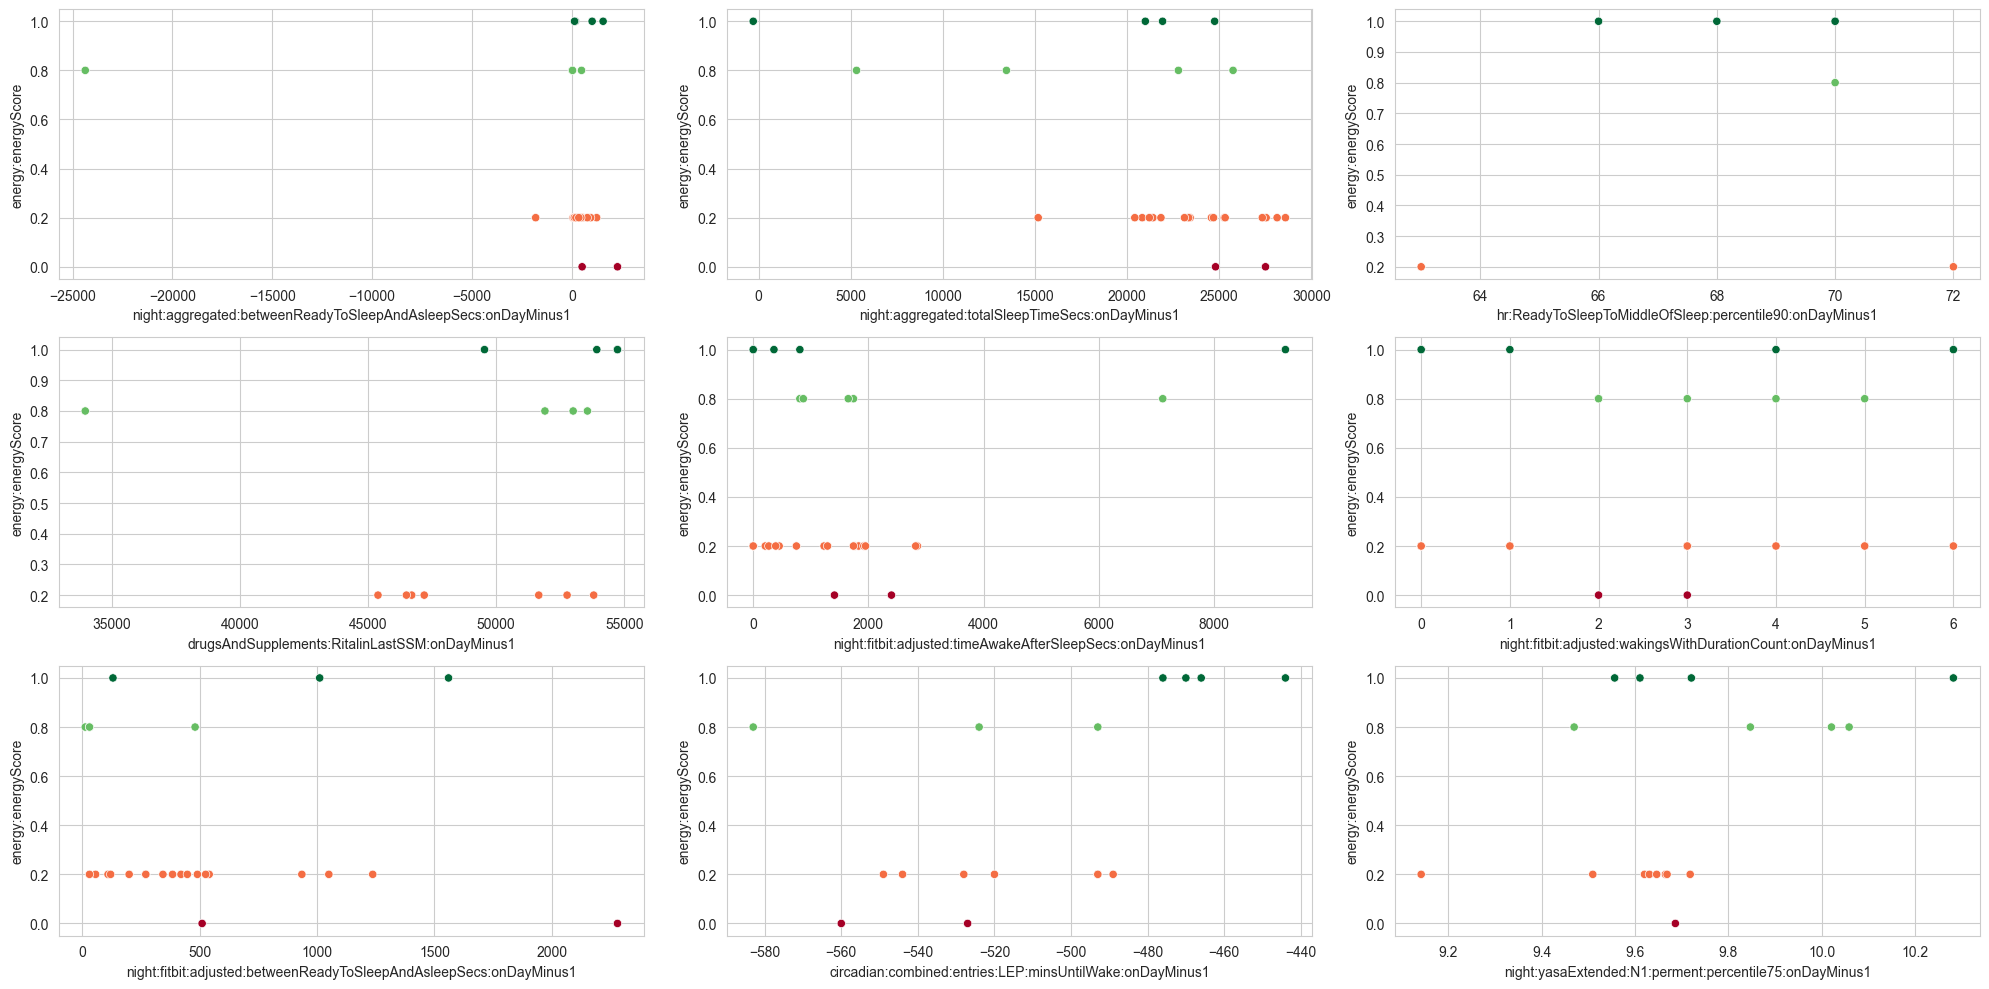

In [323]:

evaluate_feature_importance(cb_model_all_features, X_all_features, y_all_features, cb_all_selected_features)
plot_top_features(cb_model_all_features, X_all_features, y_all_features, cb_all_selected_features)

In [324]:
df_before_night = prepared_df_before_night.copy()
df_before_night["EnergyPredictionFromEEGDeep"] = y_pred_eeg_deep
df_before_night["EnergyPredictionFromAllFeatures"] = y_pred_all_features
df_before_night[["energy:energyScore", "EnergyPredictionFromEEGDeep", "EnergyPredictionFromAllFeatures"]]

,energy:energyScore,EnergyPredictionFromEEGDeep,EnergyPredictionFromAllFeatures
81,1.000,0.364,0.974
82,0.200,0.209,0.201
85,0.800,0.797,0.777
86,1.000,0.989,0.992
87,0.200,0.202,0.206
92,1.000,0.972,0.987
96,0.200,0.364,0.240
97,0.200,0.199,0.194
98,0.200,0.204,0.198
120,1.000,0.993,0.973


In [326]:
numerical_df = df_before_night.select_dtypes(include=['number'])
corr =  numerical_df.corr()
correlation_matrix_from_eeg_deep = corr['EnergyPredictionFromEEGDeep']
correlation_matrix_from_all_features = corr['EnergyPredictionFromAllFeatures']
correlation_matrix_from_all_features
# 
# # Compute the correlation matrix
# correlation_matrix = numerical_df.corr().abs()
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# 
# # Apply the mask to the correlation matrix
# masked_corr_matrix = correlation_matrix.mask(mask)

# Find the pairs of features with correlation above 95%
# high_corr_pairs = masked_corr_matrix.stack().reset_index()
# high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
# high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.95]
# 
# non_null_matrix = numerical_df.notnull().astype(int)
# 
# # Use matrix multiplication to count non-null pairs
# non_null_counts = non_null_matrix.T.dot(non_null_matrix)
# 
# out_df = df_before_night.copy()
# # Extract the counts for the high correlation pairs
# out_df['NonNullCount'] = out_df.apply(
#     lambda row: non_null_counts.loc[row['Feature1'], row['Feature2']], axis=1
# )


drugsAndSupplements:drugsAndSupplementsCount:onDayMinus1    0.143
date:year:onDayMinus1                                         NaN
exercise:fitbit:elevation:onDayMinus1                      -0.074
exercise:fitbit:heartRateZonesCount:onDayMinus1            -0.290
events:sex:count:onDayMinus1                               -0.216
                                                            ...  
coreBodyTemp:GotIntoBedToAwake:percentile90:onDayMinus1     0.096
drugsAndSupplements:ElvanseLastSSM:onDayMinus1             -0.595
drugsAndSupplements:ElvanseQuantity:onDayMinus1             0.354
EnergyPredictionFromEEGDeep                                 0.814
EnergyPredictionFromAllFeatures                             1.000
Name: EnergyPredictionFromAllFeatures, Length: 264, dtype: float64

In [312]:
# sns.scatterplot(x='drugsAndSupplements:ElvanseQuantity:onDayMinus1', y='EnergyPredictionFromEEGDeep', alpha=0.5, data=df_before_night)
# # 

<Axes: xlabel='sunExposure:firstDurationOutsideSecs:onDayMinus1', ylabel='energy:energyScore'>

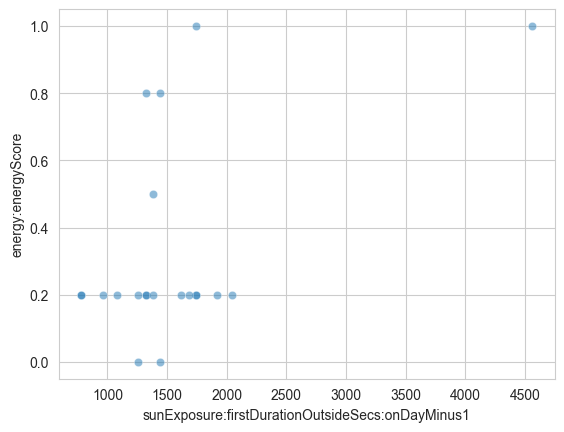

In [329]:
sns.scatterplot(x='sunExposure:firstDurationOutsideSecs:onDayMinus1', y='energy:energyScore', alpha=0.5, data=df_before_night)


In [338]:
corr_result_df = result_df.select_dtypes(include=['number']).corr()

In [339]:
corr_result_df["night.aggregated.awakeAfterSleepSecs"]

presence:presence:aggregated:graham_study:totalDurationSecs      NaN
presence:presence:aggregated:bedroom:totalDurationSecs           NaN
date:daysSince                                                   NaN
sunrise:sunsetDurationSecs                                    -0.019
presence:devices:aggregated:Work:firstUsedSSM                    NaN
                                                               ...  
events:finishedOwnWork:count:vsDayMinus1                         NaN
events:finishedOwnWork:lastSSM:onDayMinus1                       NaN
events:finishedOwnWork:firstSSM:vsDayMinus1                      NaN
events:finishedOwnWork:firstSSM:onDayMinus1                      NaN
events:finishedOwnWork:lastSSM:vsDayMinus1                       NaN
Name: night.aggregated.awakeAfterSleepSecs, Length: 10461, dtype: float64

In [331]:
[col for col in result_df.columns if 'awakeAfter' in col]

['night:aggregated:awakeAfterSleepSecs',
 'night.aggregated.awakeAfterSleepSecs',
 'night:aggregated:awakeAfterSleepSecs:vsDayMinus1',
 'night.awakeAfterSleepMillis',
 'night:aggregated:awakeAfterSleepSecs:onDayMinus1',
 'night:yasa:source:awakeAfterSleepSecs',
 'night:nightEvents:awakeAfterSleep',
 'night:fitbit:source:awakeAfterSleepSecs',
 'night:fitbit:adjusted:awakeAfterSleepSecs']

<Axes: xlabel='food:aggregated:totalCaffeineMg', ylabel='night.aggregated.awakeAfterSleepSecs'>

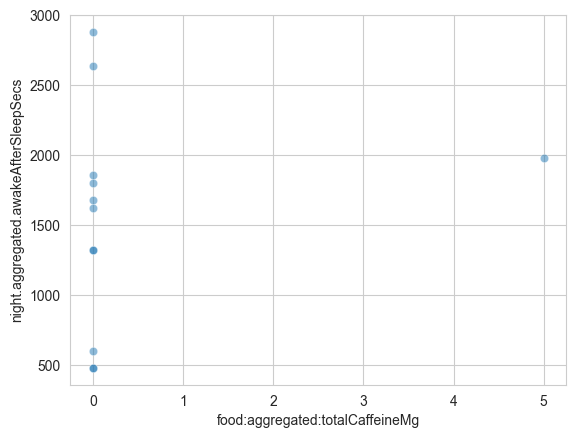

In [349]:
sns.scatterplot(x='food:aggregated:totalCaffeineMg', y='night.aggregated.awakeAfterSleepSecs', alpha=0.5, data=result_df)


In [345]:
[col for col in result_df.columns if 'Concerta' in col]


['drugsAndSupplements:ConcertaXLQuantity',
 'drugsAndSupplements:ConcertaXLLastSSM',
 'drugsAndSupplements:ConcertaXLLastSSM:onDayMinus1',
 'drugsAndSupplements:ConcertaXLQuantity:vsDayMinus1',
 'drugsAndSupplements:ConcertaXLQuantity:onDayMinus1',
 'drugsAndSupplements:ConcertaXLLastSSM:vsDayMinus1']

In [298]:
[col for col in df_before_night.columns if 'Elvanse' in col]


['drugsAndSupplements:totalElvanseCountMg',
 'drugsAndSupplements:totalElvanseCountMg:vsDayMinus1',
 'drugsAndSupplements:ElvanseLastSSM',
 'drugsAndSupplements:ElvanseQuantity',
 'drugsAndSupplements:ElvanseQuantity:vsDayMinus1',
 'drugsAndSupplements:ElvanseLastSSM:vsDayMinus1']